# Ejemplo de Pre-procesamiento de Texto en Español: Limpieza, normalización y NER
**Objetivo**: Practicar los procesos de limpieza, normalización y reconocimiento de entidades nombradasen Python.

Autor: Alexandra Pomares Q

#Agenda

1. Instalación
2. Importación librerías
3. Filtrado de ruido de origen
4. Normalización mayúscula y minúscula
5. Eliminación de acentos y demás diacríticos
6. Corrección de errores de ortografía
7. Filtrado a nivel de token
8. Filtrado de tokens basado en reglas 
9. Reconocimiento de entidades nombradas

# Instalación
!python -m spacy download es_core_news_lg
### Después de instalarlo reiniciar el entorno de ejecución con Ctrl + M + . o con Entorno de ejecución/ Reiniciar entorno de ejecución
### Atención, al reiniciarlo todas las variables cargadas en el entorno se reinician.

In [1]:
!pip install --upgrade spacy

     |████████████████████████████████| 6.4 MB 6.6 MB/s 
     |████████████████████████████████| 42 kB 1.0 MB/s 
     |████████████████████████████████| 456 kB 30.1 MB/s 
     |████████████████████████████████| 621 kB 60.9 MB/s 
     |████████████████████████████████| 10.1 MB 19.9 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [2]:
!python -m spacy download es_core_news_lg

2021-08-02 23:52:21.681183: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 568.4 MB 13 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')


In [3]:
!pip install emoji --upgrade

     |████████████████████████████████| 184 kB 7.8 MB/s 
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186469 sha256=3ce4d01153115530dae71ce94ba8692ee9329c834f0dbbe94d49e303167e487f
  Stored in directory: /root/.cache/pip/wheels/e4/61/e7/2fc1ac8f306848fc66c6c013ab511f0a39ef4b1825b11363b2
Successfully built emoji


In [4]:
!pip install pyspellchecker

     |████████████████████████████████| 2.7 MB 6.9 MB/s 


# Importación de Librerías

In [1]:
# Importación de librerías

import spacy
# Debes verificar que la versión de Spacy sea 3 o superior para que tener las últimas versiones de los modelos que usaremos.
print("spaCy version: ", spacy.__version__)
# Librería para reconocimientro y tratamiento de expresiones regulares
import re 
# Librería para reconocer emojis y expandirlos por su significado
import emoji
from emoji import demojize
# Libería para hacer revisión de ortografía
import spellchecker
from spellchecker import SpellChecker
# Para obtener directamente de una página we la información
import requests
# Para procesar el html
from bs4 import BeautifulSoup
#  Para creación de series y dataframes
import pandas as pd
import numpy as np
# Librerías para controlar los errores al cargar páginas web
import time
from urllib.error import URLError
from urllib3.exceptions import LocationParseError


# Para realizar gráficos
import numpy, matplotlib
import wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud





spaCy version:  3.1.1


# Lectura del texto de fuente de datos
Cargaremos una página web usando la librería requests y la filtraremos usando la librería beautifulsoup.

In [2]:
# A continuación seleccionamos una URL
base_url = "https://proverbia.net/frases-de-experiencia"
try:
    page = requests.get(base_url)
except requests.exceptions.ConnectionError as r:
  r.status_code = "Conexion rechazada"
  print("Conexion rechazada")
  print("Esperar 5 segundos")
  time.sleep(5)
except URLError as r:
  r.status_code = "URL error"
  print("URL error")
except LocationParseError as r:
  r.status_code = "LocationParseError"
  print("LocationParseError")
except:
    print ("Unexpected error:", sys.exc_info()[0])

# Si la respuesta no es 200 o dentro de 200 significa que no se pudo cargar correctamente
page

<Response [200]>

## Examinar el archivo fuente 
Para cada fuente es importante examinar el formato para revisar qué partes son de utilidad y así poder realizar el filtro.

In [3]:
# A continuación se examinará la página con BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')
print(soup.prettify())

<!DOCTYPE html>
<html lang="es">
 <head>
  <!-- Google Analytics -->
  <script>
   (function(i,s,o,g,r,a,m){i['GoogleAnalyticsObject']=r;i[r]=i[r]||function(){
(i[r].q=i[r].q||[]).push(arguments)},i[r].l=1*new Date();a=s.createElement(o),
m=s.getElementsByTagName(o)[0];a.async=1;a.src=g;m.parentNode.insertBefore(a,m)
})(window,document,'script','https://www.google-analytics.com/analytics.js','ga');

ga('create', 'UA-59682-6', 'auto');
ga('send', 'pageview');
  </script>
  <!-- End Google Analytics -->
  <script async="" data-ad-client="ca-pub-3410145742764658" src="https://pagead2.googlesyndication.com/pagead/js/adsbygoogle.js">
  </script>
  <meta charset="utf-8"/>
  <meta content="width=device-width, initial-scale=1.0" name="viewport"/>
  <title>
   Frases sobre la experiencia - Proverbia
  </title>
  <meta content="frases celebres,citas celebres,citas célebres,frases célebres,proverbios,famosas,citas arte,frases arte,sentimientos,aforismos,pensamientos,amor,vida,felicidad,sentencias

# Filtrado de ruido de origen
Ahora filtraremos el texto obtenido para mantener únicamente lo que es de interés. 
En este caso sólo consideraremo los que está dentro de la etiqueta \<p\> \<\/p\>

In [5]:
# Leeremos todos los textos que estén dentro de la etiqueta <p> de párrafo en html
parrafos = soup.find_all('p')

In [6]:
# Creamos un dataframe para almacenar los textos
column_names = ["url", "codigo", "texto"]
textos = pd.DataFrame(columns = column_names)
i = 0
# Por cada párrafo encontrado obtendremos los textos eliminando las etiquetas 
for texto in parrafos:
    # Acá obtenemos el texto
    t = texto.get_text()
    # Sólo consideraremos los textos que no están vacíos
    if(len(t) > 0):
      i = i+1
      # Adicionamos al data frrame
      new_row = {'url':base_url, 'codigo':i, 'texto':t}
      textos = textos.append(new_row, ignore_index = True)


In [7]:
# Imprimiremos la forma del dataframe para saber si los cargó correctamente
textos.shape

(24, 3)

In [8]:
# Ahora veremos el encabezado
textos.head()

,url,codigo,texto
0,https://proverbia.net/frases-de-experiencia,1,"La experiencia no tiene valor ético alguno, es..."
1,https://proverbia.net/frases-de-experiencia,2,"Una experiencia nunca es un fracaso, pues siem..."
2,https://proverbia.net/frases-de-experiencia,3,"La experiencia no es lo que te sucede, sino lo..."
3,https://proverbia.net/frases-de-experiencia,4,Pájaro viejo no entra en jaula.
4,https://proverbia.net/frases-de-experiencia,5,Un experto es un hombre que ha dejado de pensa...


### Expansión de emojis
en ciertas fuentes la existencia de Emojis puede ser voluminosa. Para expandir el significado del emoji y agregarlo al texto es posible usar la librería emoji.

In [17]:
textoInformal = "No me gusta el 🥑 pero me encanta comer todo lo de 🇲🇽"
textoNormalizado = demojize(textoInformal, language='es')
print(textoInformal,"--->", textoNormalizado)


No me gusta el 🥑 pero me encanta comer todo lo de 🇲🇽 ---> No me gusta el :aguacate: pero me encanta comer todo lo de :bandera_méxico:


# Normalización mayúscula y minúscula
Dejaremos todo en minúscula usando la función estándar de Strings en python lower()


In [18]:
# crearemos una nueva columna para dejar todo en minúscula
textos['textoMinuscula'] = textos['texto'].str.lower()
textos.head()



,url,codigo,texto,textoMinuscula,textoMauyuscula,textoSinAcentos
0,https://proverbia.net/frases-de-experiencia,1,"La experiencia no tiene valor ético alguno, es...","la experiencia no tiene valor ético alguno, es...","LA EXPERIENCIA NO TIENE VALOR ÉTICO ALGUNO, ES...","LA EXPERIENCIA NO TIENE VALOR ETICO ALGUNO, ES..."
1,https://proverbia.net/frases-de-experiencia,2,"Una experiencia nunca es un fracaso, pues siem...","una experiencia nunca es un fracaso, pues siem...","UNA EXPERIENCIA NUNCA ES UN FRACASO, PUES SIEM...","UNA EXPERIENCIA NUNCA ES UN FRACASO, PUES SIEM..."
2,https://proverbia.net/frases-de-experiencia,3,"La experiencia no es lo que te sucede, sino lo...","la experiencia no es lo que te sucede, sino lo...","LA EXPERIENCIA NO ES LO QUE TE SUCEDE, SINO LO...","LA EXPERIENCIA NO ES LO QUE TE SUCEDE, SINO LO..."
3,https://proverbia.net/frases-de-experiencia,4,Pájaro viejo no entra en jaula.,pájaro viejo no entra en jaula.,PÁJARO VIEJO NO ENTRA EN JAULA.,PAJARO VIEJO NO ENTRA EN JAULA.
4,https://proverbia.net/frases-de-experiencia,5,Un experto es un hombre que ha dejado de pensa...,un experto es un hombre que ha dejado de pensa...,UN EXPERTO ES UN HOMBRE QUE HA DEJADO DE PENSA...,UN EXPERTO ES UN HOMBRE QUE HA DEJADO DE PENSA...


## Ahora tú 
Crea otra columna para dejar todo en mayúscula

In [19]:
# Escribe tu código acá
textos['textoMauyuscula'] = textos['texto'].str.upper()
textos.head()

,url,codigo,texto,textoMinuscula,textoMauyuscula,textoSinAcentos
0,https://proverbia.net/frases-de-experiencia,1,"La experiencia no tiene valor ético alguno, es...","la experiencia no tiene valor ético alguno, es...","LA EXPERIENCIA NO TIENE VALOR ÉTICO ALGUNO, ES...","LA EXPERIENCIA NO TIENE VALOR ETICO ALGUNO, ES..."
1,https://proverbia.net/frases-de-experiencia,2,"Una experiencia nunca es un fracaso, pues siem...","una experiencia nunca es un fracaso, pues siem...","UNA EXPERIENCIA NUNCA ES UN FRACASO, PUES SIEM...","UNA EXPERIENCIA NUNCA ES UN FRACASO, PUES SIEM..."
2,https://proverbia.net/frases-de-experiencia,3,"La experiencia no es lo que te sucede, sino lo...","la experiencia no es lo que te sucede, sino lo...","LA EXPERIENCIA NO ES LO QUE TE SUCEDE, SINO LO...","LA EXPERIENCIA NO ES LO QUE TE SUCEDE, SINO LO..."
3,https://proverbia.net/frases-de-experiencia,4,Pájaro viejo no entra en jaula.,pájaro viejo no entra en jaula.,PÁJARO VIEJO NO ENTRA EN JAULA.,PAJARO VIEJO NO ENTRA EN JAULA.
4,https://proverbia.net/frases-de-experiencia,5,Un experto es un hombre que ha dejado de pensa...,un experto es un hombre que ha dejado de pensa...,UN EXPERTO ES UN HOMBRE QUE HA DEJADO DE PENSA...,UN EXPERTO ES UN HOMBRE QUE HA DEJADO DE PENSA...


# Eliminación de acentos
Para eliminar acentos nos valdemos de la librería unicodedata. Unicode es un consorcio que mantiene el estándar de caracteres incluyendo su representación y codificación https://home.unicode.org/

In [20]:
import unicodedata
def strip_accents(s):
   # Retorna el string normalizado si la categoría es Mn es decir https://www.compart.com/en/unicode/category/Mn
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

In [21]:
# Ahora crearemos un texto sin acentos en una nueva columna
textos['textoSinAcentos'] = textos['textoMinuscula'].apply(strip_accents)


In [22]:
# Observemos la columna final y comparémosla con el texto original
textos

,url,codigo,texto,textoMinuscula,textoMauyuscula,textoSinAcentos
0,https://proverbia.net/frases-de-experiencia,1,"La experiencia no tiene valor ético alguno, es...","la experiencia no tiene valor ético alguno, es...","LA EXPERIENCIA NO TIENE VALOR ÉTICO ALGUNO, ES...","la experiencia no tiene valor etico alguno, es..."
1,https://proverbia.net/frases-de-experiencia,2,"Una experiencia nunca es un fracaso, pues siem...","una experiencia nunca es un fracaso, pues siem...","UNA EXPERIENCIA NUNCA ES UN FRACASO, PUES SIEM...","una experiencia nunca es un fracaso, pues siem..."
2,https://proverbia.net/frases-de-experiencia,3,"La experiencia no es lo que te sucede, sino lo...","la experiencia no es lo que te sucede, sino lo...","LA EXPERIENCIA NO ES LO QUE TE SUCEDE, SINO LO...","la experiencia no es lo que te sucede, sino lo..."
3,https://proverbia.net/frases-de-experiencia,4,Pájaro viejo no entra en jaula.,pájaro viejo no entra en jaula.,PÁJARO VIEJO NO ENTRA EN JAULA.,pajaro viejo no entra en jaula.
4,https://proverbia.net/frases-de-experiencia,5,Un experto es un hombre que ha dejado de pensa...,un experto es un hombre que ha dejado de pensa...,UN EXPERTO ES UN HOMBRE QUE HA DEJADO DE PENSA...,un experto es un hombre que ha dejado de pensa...
5,https://proverbia.net/frases-de-experiencia,6,La experiencia del mundo no consiste en el núm...,la experiencia del mundo no consiste en el núm...,LA EXPERIENCIA DEL MUNDO NO CONSISTE EN EL NÚM...,la experiencia del mundo no consiste en el num...
6,https://proverbia.net/frases-de-experiencia,7,"La experiencia es algo maravilloso, nos permit...","la experiencia es algo maravilloso, nos permit...","LA EXPERIENCIA ES ALGO MARAVILLOSO, NOS PERMIT...","la experiencia es algo maravilloso, nos permit..."
7,https://proverbia.net/frases-de-experiencia,8,Experiencia es el nombre que damos a nuestras ...,experiencia es el nombre que damos a nuestras ...,EXPERIENCIA ES EL NOMBRE QUE DAMOS A NUESTRAS ...,experiencia es el nombre que damos a nuestras ...
8,https://proverbia.net/frases-de-experiencia,9,Sólo una cosa es más dolorosa que aprender de ...,sólo una cosa es más dolorosa que aprender de ...,SÓLO UNA COSA ES MÁS DOLOROSA QUE APRENDER DE ...,solo una cosa es mas dolorosa que aprender de ...
9,https://proverbia.net/frases-de-experiencia,10,"Paréceme, Sancho, que no hay refrán que no sea...","paréceme, sancho, que no hay refrán que no sea...","PARÉCEME, SANCHO, QUE NO HAY REFRÁN QUE NO SEA...","pareceme, sancho, que no hay refran que no sea..."


# Corrección de errores de ortografía
Para corregir errores de ortogafía usaremos la librería pyspellchecker pues tiene implementación en Español. Esta librería está basada en el cálculo de la distancia de Levensthein.

In [38]:
# Adicionaremos una fila con texto con errores.
new_text = 'Para el que no sabe a donee queire llegar culquier camnio es corretco'
new_row = {'url':'http://localhost.com', 'codigo': 1, 'texto': new_text, 'textoMinuscula' : new_text.lower()}
textos = textos.append(new_row, ignore_index = True)


In [39]:
textos.tail()

,url,codigo,texto,textoMinuscula,textoMauyuscula,textoSinAcentos,textoCorregido
20,https://proverbia.net/frases-de-experiencia,21,Nunca le ha servido a nadie la experiencia de ...,nunca le ha servido a nadie la experiencia de ...,NUNCA LE HA SERVIDO A NADIE LA EXPERIENCIA DE ...,nunca le ha servido a nadie la experiencia de ...,nunca le ha servido a nadie la experiencia de ...
21,https://proverbia.net/frases-de-experiencia,22,"No escribo sobre mis experiencias, sino desde ...","no escribo sobre mis experiencias, sino desde ...","NO ESCRIBO SOBRE MIS EXPERIENCIAS, SINO DESDE ...","no escribo sobre mis experiencias, sino desde ...",no escribo sobre mis experiencias sino desde f...
22,https://proverbia.net/frases-de-experiencia,23,La experiencia es como un billete de lotería c...,la experiencia es como un billete de lotería c...,LA EXPERIENCIA ES COMO UN BILLETE DE LOTERÍA C...,la experiencia es como un billete de loteria c...,la experiencia es como un billete de lotería c...
23,https://proverbia.net/frases-de-experiencia,24,"Un grano de buena experiencia a los 9 años, va...","un grano de buena experiencia a los 9 años, va...","UN GRANO DE BUENA EXPERIENCIA A LOS 9 AÑOS, VA...","un grano de buena experiencia a los 9 anos, va...",un grano de buena experiencia a los 9 años val...
24,http://localhost.com,1,Para el que no sabe a donee queire llegar culq...,para el que no sabe a donee queire llegar culq...,NaN,NaN,NaN


In [40]:
# crearemos la función para corregir los errores de un texto. Es importante tener en cuenta que si la palabra no está
# en el diccionario buscará la más parecida, pero si no encuentra ninguna parecida no la corrige.

def corregirTexto(text):  
  spell = SpellChecker(language='es')
  textoCorregido = ''
  for word in text.split():
    if not(word in spell):
      textoCorregido = textoCorregido + spell.correction(word)+' '
    else:
      textoCorregido = textoCorregido + word + ' '
  return textoCorregido  



In [41]:
textos['textoCorregido'] = textos['textoMinuscula'].apply(corregirTexto)


In [42]:
textos.tail()

,url,codigo,texto,textoMinuscula,textoMauyuscula,textoSinAcentos,textoCorregido
20,https://proverbia.net/frases-de-experiencia,21,Nunca le ha servido a nadie la experiencia de ...,nunca le ha servido a nadie la experiencia de ...,NUNCA LE HA SERVIDO A NADIE LA EXPERIENCIA DE ...,nunca le ha servido a nadie la experiencia de ...,nunca le ha servido a nadie la experiencia de ...
21,https://proverbia.net/frases-de-experiencia,22,"No escribo sobre mis experiencias, sino desde ...","no escribo sobre mis experiencias, sino desde ...","NO ESCRIBO SOBRE MIS EXPERIENCIAS, SINO DESDE ...","no escribo sobre mis experiencias, sino desde ...",no escribo sobre mis experiencias sino desde f...
22,https://proverbia.net/frases-de-experiencia,23,La experiencia es como un billete de lotería c...,la experiencia es como un billete de lotería c...,LA EXPERIENCIA ES COMO UN BILLETE DE LOTERÍA C...,la experiencia es como un billete de loteria c...,la experiencia es como un billete de lotería c...
23,https://proverbia.net/frases-de-experiencia,24,"Un grano de buena experiencia a los 9 años, va...","un grano de buena experiencia a los 9 años, va...","UN GRANO DE BUENA EXPERIENCIA A LOS 9 AÑOS, VA...","un grano de buena experiencia a los 9 anos, va...",un grano de buena experiencia a los 9 años val...
24,http://localhost.com,1,Para el que no sabe a donee queire llegar culq...,para el que no sabe a donee queire llegar culq...,NaN,NaN,para el que no sabe a donde queire llegar culq...


In [43]:
# Borraremos el texto adicionado
textos.drop([24],inplace=True)

# Filtrado de tokens
Para realizar el filtrado de tokens primero debemos procesar los textos para generar los documentos con las etiquetas por cada token. Usaremos el modelo es_core_news_lg

In [44]:
# cargaremos el modelo para poder aplicar el pipeluine
nlpSpa = spacy.load('es_core_news_lg')

In [45]:
# Ahora aplicaremos todo el pipeline a los textos del data frame
textos['doc'] = textos['textoMinuscula'].apply(nlpSpa)
textos.head()



,url,codigo,texto,textoMinuscula,textoMauyuscula,textoSinAcentos,textoCorregido,doc
0,https://proverbia.net/frases-de-experiencia,1,"La experiencia no tiene valor ético alguno, es...","la experiencia no tiene valor ético alguno, es...","LA EXPERIENCIA NO TIENE VALOR ÉTICO ALGUNO, ES...","la experiencia no tiene valor etico alguno, es...",la experiencia no tiene valor ético algunos es...,"(la, experiencia, no, tiene, valor, ético, alg..."
1,https://proverbia.net/frases-de-experiencia,2,"Una experiencia nunca es un fracaso, pues siem...","una experiencia nunca es un fracaso, pues siem...","UNA EXPERIENCIA NUNCA ES UN FRACASO, PUES SIEM...","una experiencia nunca es un fracaso, pues siem...",una experiencia nunca es un fracaso pues siemp...,"(una, experiencia, nunca, es, un, fracaso, ,, ..."
2,https://proverbia.net/frases-de-experiencia,3,"La experiencia no es lo que te sucede, sino lo...","la experiencia no es lo que te sucede, sino lo...","LA EXPERIENCIA NO ES LO QUE TE SUCEDE, SINO LO...","la experiencia no es lo que te sucede, sino lo...",la experiencia no es lo que te sucede sino lo ...,"(la, experiencia, no, es, lo, que, te, sucede,..."
3,https://proverbia.net/frases-de-experiencia,4,Pájaro viejo no entra en jaula.,pájaro viejo no entra en jaula.,PÁJARO VIEJO NO ENTRA EN JAULA.,pajaro viejo no entra en jaula.,pájaro viejo no entra en jaula,"(pájaro, viejo, no, entra, en, jaula, .)"
4,https://proverbia.net/frases-de-experiencia,5,Un experto es un hombre que ha dejado de pensa...,un experto es un hombre que ha dejado de pensa...,UN EXPERTO ES UN HOMBRE QUE HA DEJADO DE PENSA...,un experto es un hombre que ha dejado de pensa...,un experto es un hombre que ha dejado de pensa...,"(un, experto, es, un, hombre, que, ha, dejado,..."


## Revisaremos los tokens generados para el documento 1 (0)

In [46]:
for token in textos['doc'][0]:
  print(token.text)

la
experiencia
no
tiene
valor
ético
alguno
,
es
simplemente
el
nombre
que
damos
a
nuestros
errores
.


## Filtrado de signos de puntuación y espacios extra

In [47]:
# Crearemos un nuevo documento en el que filtraremos algunos tokens. 
# Para hacerlo definiremos un nuevo componente para agregar al pipeline que nos permita filtrar los tokens no deseados
# Específicamente eliminaremos los signos de puntuación y los espacios dobles, si existen
def filter_punct_Space(doc):
  # Filtraremos los signos de puntuación y los espacios extra
  doc = [token for token in doc if not token.is_punct and not token.is_space]
  return doc


In [48]:
# Ahora aplicaremos la función creada
textos['doc2'] = textos['doc'].apply(filter_punct_Space)
textos.head()

,url,codigo,texto,textoMinuscula,textoMauyuscula,textoSinAcentos,textoCorregido,doc,doc2
0,https://proverbia.net/frases-de-experiencia,1,"La experiencia no tiene valor ético alguno, es...","la experiencia no tiene valor ético alguno, es...","LA EXPERIENCIA NO TIENE VALOR ÉTICO ALGUNO, ES...","la experiencia no tiene valor etico alguno, es...",la experiencia no tiene valor ético algunos es...,"(la, experiencia, no, tiene, valor, ético, alg...","[la, experiencia, no, tiene, valor, ético, alg..."
1,https://proverbia.net/frases-de-experiencia,2,"Una experiencia nunca es un fracaso, pues siem...","una experiencia nunca es un fracaso, pues siem...","UNA EXPERIENCIA NUNCA ES UN FRACASO, PUES SIEM...","una experiencia nunca es un fracaso, pues siem...",una experiencia nunca es un fracaso pues siemp...,"(una, experiencia, nunca, es, un, fracaso, ,, ...","[una, experiencia, nunca, es, un, fracaso, pue..."
2,https://proverbia.net/frases-de-experiencia,3,"La experiencia no es lo que te sucede, sino lo...","la experiencia no es lo que te sucede, sino lo...","LA EXPERIENCIA NO ES LO QUE TE SUCEDE, SINO LO...","la experiencia no es lo que te sucede, sino lo...",la experiencia no es lo que te sucede sino lo ...,"(la, experiencia, no, es, lo, que, te, sucede,...","[la, experiencia, no, es, lo, que, te, sucede,..."
3,https://proverbia.net/frases-de-experiencia,4,Pájaro viejo no entra en jaula.,pájaro viejo no entra en jaula.,PÁJARO VIEJO NO ENTRA EN JAULA.,pajaro viejo no entra en jaula.,pájaro viejo no entra en jaula,"(pájaro, viejo, no, entra, en, jaula, .)","[pájaro, viejo, no, entra, en, jaula]"
4,https://proverbia.net/frases-de-experiencia,5,Un experto es un hombre que ha dejado de pensa...,un experto es un hombre que ha dejado de pensa...,UN EXPERTO ES UN HOMBRE QUE HA DEJADO DE PENSA...,un experto es un hombre que ha dejado de pensa...,un experto es un hombre que ha dejado de pensa...,"(un, experto, es, un, hombre, que, ha, dejado,...","[un, experto, es, un, hombre, que, ha, dejado,..."


## Revisaremos los tokens después del filtrado

In [ ]:
print("Tokens originales")
for token in textos['doc'][0]:
  print(token.text)
print("Tokens después del filtro")
for token in textos['doc2'][0]:
  print(token.text)

Tokens originales
la
experiencia
no
tiene
valor
ético
alguno
,
es
simplemente
el
nombre
que
damos
a
nuestros
errores
.
Tokens después del filtro
la
experiencia
no
tiene
valor
ético
alguno
es
simplemente
el
nombre
que
damos
a
nuestros
errores


## Ahora tú: 1
Crea una función que elimine los números y adiciona una columna que se llame docSinNumeros

In [ ]:
# Escribe tu código acá

## Filtrado de tokens usando sus características morfo-léxicas
Filtraremos para dejar únicamente los sustantivos, verbos y adjetivos. Recuerda los metadatos [acá](https://universaldependencies.org/docs/u/pos/). 

In [49]:
# Crearemos un nuevo documento en el que filtraremos algunos tokens. 
# Para hacerlo definiremos un nuevo componente para agregar al pipeline que nos permita filtrar los tokens no deseados
# Específicamente eliminaremos los signos de puntuación y los espacios dobles, si existen
def filter_NVJ(doc):
  # Filtraremos los signos de puntuación y los espacios extra
  doc = [token for token in doc if token.pos_ in ('VERB', 'ADJ','NOUN','PROPN')]
  return doc


In [50]:
# Ahora aplicaremos la función creada
textos['doc3'] = textos['doc'].apply(filter_NVJ)
textos.head()

,url,codigo,texto,textoMinuscula,textoMauyuscula,textoSinAcentos,textoCorregido,doc,doc2,doc3
0,https://proverbia.net/frases-de-experiencia,1,"La experiencia no tiene valor ético alguno, es...","la experiencia no tiene valor ético alguno, es...","LA EXPERIENCIA NO TIENE VALOR ÉTICO ALGUNO, ES...","la experiencia no tiene valor etico alguno, es...",la experiencia no tiene valor ético algunos es...,"(la, experiencia, no, tiene, valor, ético, alg...","[la, experiencia, no, tiene, valor, ético, alg...","[experiencia, tiene, valor, ético, nombre, dam..."
1,https://proverbia.net/frases-de-experiencia,2,"Una experiencia nunca es un fracaso, pues siem...","una experiencia nunca es un fracaso, pues siem...","UNA EXPERIENCIA NUNCA ES UN FRACASO, PUES SIEM...","una experiencia nunca es un fracaso, pues siem...",una experiencia nunca es un fracaso pues siemp...,"(una, experiencia, nunca, es, un, fracaso, ,, ...","[una, experiencia, nunca, es, un, fracaso, pue...","[experiencia, fracaso, viene, demostrar]"
2,https://proverbia.net/frases-de-experiencia,3,"La experiencia no es lo que te sucede, sino lo...","la experiencia no es lo que te sucede, sino lo...","LA EXPERIENCIA NO ES LO QUE TE SUCEDE, SINO LO...","la experiencia no es lo que te sucede, sino lo...",la experiencia no es lo que te sucede sino lo ...,"(la, experiencia, no, es, lo, que, te, sucede,...","[la, experiencia, no, es, lo, que, te, sucede,...","[experiencia, sucede, haces, sucede]"
3,https://proverbia.net/frases-de-experiencia,4,Pájaro viejo no entra en jaula.,pájaro viejo no entra en jaula.,PÁJARO VIEJO NO ENTRA EN JAULA.,pajaro viejo no entra en jaula.,pájaro viejo no entra en jaula,"(pájaro, viejo, no, entra, en, jaula, .)","[pájaro, viejo, no, entra, en, jaula]","[pájaro, viejo, entra, jaula]"
4,https://proverbia.net/frases-de-experiencia,5,Un experto es un hombre que ha dejado de pensa...,un experto es un hombre que ha dejado de pensa...,UN EXPERTO ES UN HOMBRE QUE HA DEJADO DE PENSA...,un experto es un hombre que ha dejado de pensa...,un experto es un hombre que ha dejado de pensa...,"(un, experto, es, un, hombre, que, ha, dejado,...","[un, experto, es, un, hombre, que, ha, dejado,...","[experto, hombre, dejado, pensar, sabe]"


## Nube de palabras filtradas
Ahora graficaremos una nube de palabras con los tokens. Usaremos la librería wordcloud y matplotlib para hacer el gráfico.


In [52]:
palabrasNube=""
for doc in textos['doc3']:
  for token in doc:
    palabrasNube = palabrasNube + token.lemma_ +  " "
palabrasNube
 

'experiencia tener valor ético nombre dar error experiencia fracaso venir demostrar experiencia suceder hacer suceder pájaro viejo entrar jaula experto hombre dejar pensar saber experiencia mundo consistir número cosa ver número cosa reflexionar fruto experiencia maravilloso permitir reconocer error vez volver cometer experiencia nombre dar equivocación cosa doloroso aprender experiencia aprender experiencia paréceme sancho refrán verdadero sentencia sacada mesma experiencia madre ciencia saber medio experiencia experiencia bastón ciego mayoría hombre experiencia luz popa barco iluminar camino quedar espalda hombre hombre gran diferencia superioridad consistir aprovechar lección experiencia espina experiencia valer bosque advertencia experiencia atribuir persona edad peor atribuir gran marinero navegar vela alquiler experiencia conseguir necesitar él experiencia tener utilidad billete lotería sorteo experimentado externo pertenecer interno intencional experiencia residir experiencia ex

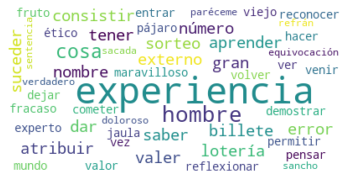

In [53]:
nube = WordCloud(max_words = 50, contour_color = "green", background_color = "white")
nube.generate(palabrasNube)
plt.figure()
plt.imshow(nube, interpolation = "bilinear")
plt.axis("off")
figura = plt.show()

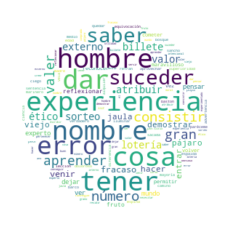

In [54]:
# Se pueden usar diferentes formas, consulta https://amueller.github.io/word_cloud/references.html
x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)


wc = WordCloud(background_color="white", repeat=True, mask=mask)
wc.generate(palabrasNube)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

## Ahora tú: 2
Crea una nube de palabras que incluya también adjetivos y use una imagen de forma. Puedes elegir la imagen que más te guste. Tipo: https://amueller.github.io/word_cloud/references.html

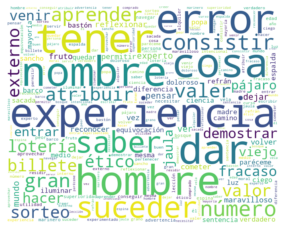

In [66]:

# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
from PIL import Image
from os import path

alice_mask = np.array(Image.open("/content/lobo.png"))

wc = WordCloud(background_color="white", repeat=True, mask=alice_mask)
wc.generate(palabrasNube)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

# Filtrado de tokens basado en reglas
A continuación extraeremos de los textos porciones completas (no un solo token) que cumplan con un patrón, teniendo en cuenta no sólo el texto, sino las etiquetas de los tokens. 

Casi toda la información de las etiquetas, incluidos el PoS la podemos usar para aplicar reglas sobre los textos y así reconocer patrones. Por ejemplo, si queremos obtener todos los verbos que vienen seguidos de un número y luego una expresión de dosificación como mililitros o miligramos podemos crear un patrón y agregarlos a la clase Matcher. Puedes practicar construyendo reglas acá: https://explosion.ai/demos/matcher
El matcher se puede ver como un componente para expresar expresiones regulares usando las etiquetas generadas por Spacy.

Para ver la documentación del Matcher, puede remitirse a https://spacy.io/api/matcher

## Revisión de etiquetas

In [ ]:
# Antes de generar los patrones imprimiremos un subconjunto de las etiquetas de un documento
# Encabezados
print('{:15} | {:5} | {:3} | {:11} | {:60} | {:8} | {:15} | '.format(
    'TOKEN','TAG','POS', 'DEP','MORPHO','IS_ALPHA','HEAD'))

# Etiquetas generadas por el pipeline por defecto (algunas de ellas)
for token in textos['doc'][17]:
    print('{:15} | {:5} | {:3} | {:11} | {:60} | {:8} | {:15} |'.format(
          token.text, token.tag_, token.idx, token.dep_,
          str(token.morph), token.is_alpha, token.head.text))
    

TOKEN           | TAG   | POS | DEP         | MORPHO                                                       | IS_ALPHA | HEAD            | 
nunca           | ADV   |   0 | advmod      |                                                              |        1 | servido         |
le              | PRON  |   6 | obj         | Case=Dat|Number=Sing|Person=3|PronType=Prs                   |        1 | servido         |
ha              | AUX   |   9 | aux         | Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin        |        1 | servido         |
servido         | VERB  |  12 | ROOT        | Gender=Masc|Number=Sing|Tense=Past|VerbForm=Part             |        1 | servido         |
a               | ADP   |  20 | case        | AdpType=Prep                                                 |        1 | nadie           |
nadie           | PRON  |  22 | obj         | Number=Sing|PronType=Neg                                     |        1 | servido         |
la              | DET   |  28 | d

## Generación de los patrones

In [ ]:
from spacy.matcher import Matcher
matcher = Matcher(nlpSpa.vocab)
patron = [{'POS': {"IN": ["NOUN", "PROPN"]}, 'OP': '+'}, # uno o más Sustantivo o nombre propio
          {'IS_ALPHA': True, 'OP': '*'}, # cero o más palabras
          {'POS': {"IN": ["AUX", "VERB"]}, 'OP': '+'}, # uno o más verbos
          {'IS_ALPHA': True, 'OP': '*'}, # cero o más palabras
          {'POS': {"IN": ["ADJ", "ADV","NOUN", "PROPN", "VERB"]}, 'OP': '+'}]# uno o más Adjetivo, Adverbio o Sustantivo o nombre propio

matcher.add("Expresivo", [patron], greedy = 'LONGEST')


In [ ]:
patron2 = [{ 'POS': {"IN": ["VERB", "AUX"]}, 'OP': '+', "IS_SENT_START": True}] # uno o más Verbo o Auxiliar
matcher.add("SV", [patron2], greedy = 'LONGEST')

In [ ]:
print(spacy.explain('PROPN'))

proper noun


## Búsqueda del patrón en el texto

In [ ]:
def matcherSelector(doc):
  # Aplicaremos el matcher sobre los documentos para ver en cuáles encuentra coincidencia
  matches = matcher(doc)
  # Ahora revisaremos si encontró el patrón en el texto.
  results = []
  for match_id, start, end in matches:
    string_id = nlpSpa.vocab.strings[match_id]  # Toma la representación del String
    span = doc[start:end]  # El span del documento que cumple con la regla, star y end es el token inicial y final del span
    #print(match_id, string_id, start, end, span.text)
    results.append([token for token in span])
  #print(doc)
  #print(results)
  return results

In [ ]:
textos['matchDoc'] = textos['doc'].apply(matcherSelector)

In [ ]:
textos

,url,codigo,texto,textoMinuscula,textoSinAcentos,textoCorregido,doc,doc2,doc3,matchDoc
0,https://proverbia.net/frases-de-experiencia,1,"La experiencia no tiene valor ético alguno, es...","la experiencia no tiene valor ético alguno, es...","la experiencia no tiene valor etico alguno, es...",la experiencia no tiene valor ético algunos es...,"(la, experiencia, no, tiene, valor, ético, alg...","[la, experiencia, no, tiene, valor, ético, alg...","[experiencia, tiene, valor, ético, nombre, dam...","[[nombre, que, damos, a, nuestros, errores], [..."
1,https://proverbia.net/frases-de-experiencia,2,"Una experiencia nunca es un fracaso, pues siem...","una experiencia nunca es un fracaso, pues siem...","una experiencia nunca es un fracaso, pues siem...",una experiencia nunca es un fracaso pues siemp...,"(una, experiencia, nunca, es, un, fracaso, ,, ...","[una, experiencia, nunca, es, un, fracaso, pue...","[experiencia, fracaso, viene, demostrar]","[[experiencia, nunca, es, un, fracaso]]"
2,https://proverbia.net/frases-de-experiencia,3,"La experiencia no es lo que te sucede, sino lo...","la experiencia no es lo que te sucede, sino lo...","la experiencia no es lo que te sucede, sino lo...",la experiencia no es lo que te sucede sino lo ...,"(la, experiencia, no, es, lo, que, te, sucede,...","[la, experiencia, no, es, lo, que, te, sucede,...","[experiencia, sucede, haces, sucede]","[[experiencia, no, es, lo, que, te, sucede]]"
3,https://proverbia.net/frases-de-experiencia,4,Pájaro viejo no entra en jaula.,pájaro viejo no entra en jaula.,pajaro viejo no entra en jaula.,pájaro viejo no entra en jaula,"(pájaro, viejo, no, entra, en, jaula, .)","[pájaro, viejo, no, entra, en, jaula]","[pájaro, viejo, entra, jaula]","[[pájaro, viejo, no, entra, en, jaula]]"
4,https://proverbia.net/frases-de-experiencia,5,Un experto es un hombre que ha dejado de pensa...,un experto es un hombre que ha dejado de pensa...,un experto es un hombre que ha dejado de pensa...,un experto es un hombre que ha dejado de pensa...,"(un, experto, es, un, hombre, que, ha, dejado,...","[un, experto, es, un, hombre, que, ha, dejado,...","[experto, hombre, dejado, pensar, sabe]","[[experto, es, un, hombre, que, ha, dejado, de..."
5,https://proverbia.net/frases-de-experiencia,6,La experiencia del mundo no consiste en el núm...,la experiencia del mundo no consiste en el núm...,la experiencia del mundo no consiste en el num...,la experiencia del mundo no consiste en el núm...,"(la, experiencia, del, mundo, no, consiste, en...","[la, experiencia, del, mundo, no, consiste, en...","[experiencia, mundo, consiste, número, cosas, ...","[[experiencia, del, mundo, no, consiste, en, e..."
6,https://proverbia.net/frases-de-experiencia,7,Experiencia es el nombre que damos a nuestras ...,experiencia es el nombre que damos a nuestras ...,experiencia es el nombre que damos a nuestras ...,experiencia es el nombre que damos a nuestras ...,"(experiencia, es, el, nombre, que, damos, a, n...","[experiencia, es, el, nombre, que, damos, a, n...","[experiencia, nombre, damos, equivocaciones]","[[experiencia, es, el, nombre, que, damos, a, ..."
7,https://proverbia.net/frases-de-experiencia,8,"La experiencia es algo maravilloso, nos permit...","la experiencia es algo maravilloso, nos permit...","la experiencia es algo maravilloso, nos permit...",la experiencia es algo maravilloso nos permite...,"(la, experiencia, es, algo, maravilloso, ,, no...","[la, experiencia, es, algo, maravilloso, nos, ...","[experiencia, maravilloso, permite, reconocer,...","[[error, cada, vez, que, lo, volvemos, a, come..."
8,https://proverbia.net/frases-de-experiencia,9,Sólo una cosa es más dolorosa que aprender de ...,sólo una cosa es más dolorosa que aprender de ...,solo una cosa es mas dolorosa que aprender de ...,sólo una cosa es más dolorosa que aprender de ...,"(sólo, una, cosa, es, más, dolorosa, que, apre...","[sólo, una, cosa, es, más, dolorosa, que, apre...","[cosa, dolorosa, aprender, experiencia, aprend...","[[cosa, es, 

## Ahora tú: 3
Escribe un patrón que permita reconocer las frases que inician con un Adverbio y contienen almenos una palabra de género femenino.

In [ ]:
# Ecribe el código aquí

# Reconocimiento de entidades
Ahora revisaremos las entidades nombradas reconocidas en un pipeline. 

## Cargaremos un archivo de noticias para reconocer entidades nombradas
Usaremos una fuente que por su naturaleza tiene varias entidades nombradas, un periódico.

In [ ]:

# A continuación seleccionamos una URL
base_url = "https://www.elespectador.com/mundo/america/quien-detiene-a-daniel-ortega/"
try:
    page = requests.get(base_url)
except requests.exceptions.ConnectionError as r:
  r.status_code = "Conexion rechazada"
  print("Conexion rechazada")
  print("Esperar 5 segundos")
  time.sleep(5)
except URLError as r:
  r.status_code = "URL error"
  print("URL error")
except LocationParseError as r:
  r.status_code = "LocationParseError"
  print("LocationParseError")
except:
    print ("Unexpected error:", sys.exc_info()[0])

# Si la respuesta no es 200 o dentro de 200 significa que no se pudo cargar correctamente
page

<Response [200]>

In [ ]:
# A continuación se examinará la página con BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')
#print(soup.prettify())

In [ ]:
# Leeremos todos los textos que estén dentro de la etiqueta <p> de párrafo en html
parrafos = soup.find_all('p')

In [ ]:
# Creamos un dataframe para almacenar las noticias
column_names = ["url", "codigo", "texto"]
noticias = pd.DataFrame(columns = column_names)
i = 0
# Por cada párrafo encontrado obtendremos los textos eliminando las etiquetas 
for texto in parrafos:
    # Acá obtenemos el texto
    t = texto.get_text()
    # Sólo consideraremos los textos que no están vacíos
    if(len(t) > 0):
      i = i+1
      # Adicionamos al data frrame
      new_row = {'url':base_url, 'codigo':i, 'texto':t}
      noticias = noticias.append(new_row, ignore_index = True)

In [ ]:
noticias.shape

(15, 3)

In [ ]:
noticias.head()

,url,codigo,texto
0,https://www.elespectador.com/mundo/america/qui...,1,El 28 de agosto de 2020 se desató en Nicaragua...
1,https://www.elespectador.com/mundo/america/qui...,2,"La nueva ola represiva, que se desató hace dos..."
2,https://www.elespectador.com/mundo/america/qui...,3,Le puede interesar: La tormenta latinoamericana
3,https://www.elespectador.com/mundo/america/qui...,4,¿Qué busca el clan Ortega? De acuerdo con Serg...
4,https://www.elespectador.com/mundo/america/qui...,5,"Y nada parece detenerlo. Estados Unidos, Canad..."


## Aplicaremos el pipeline a los párrafos cargados

In [ ]:
noticias['doc'] = noticias['texto'].apply(nlpSpa)
noticias.head()

,url,codigo,texto,doc
0,https://www.elespectador.com/mundo/america/qui...,1,El 28 de agosto de 2020 se desató en Nicaragua...,"(El, 28, de, agosto, de, 2020, se, desató, en,..."
1,https://www.elespectador.com/mundo/america/qui...,2,"La nueva ola represiva, que se desató hace dos...","(La, nueva, ola, represiva, ,, que, se, desató..."
2,https://www.elespectador.com/mundo/america/qui...,3,Le puede interesar: La tormenta latinoamericana,"(Le, puede, interesar, :, La, tormenta, latino..."
3,https://www.elespectador.com/mundo/america/qui...,4,¿Qué busca el clan Ortega? De acuerdo con Serg...,"(¿, Qué, busca, el, clan, Ortega, ?, De, acuer..."
4,https://www.elespectador.com/mundo/america/qui...,5,"Y nada parece detenerlo. Estados Unidos, Canad...","(Y, nada, parece, detenerlo, ., Estados, Unido..."


## Revisión de entidades reconocidas

In [ ]:
from spacy import displacy
# Entidades reconocidas
for doc in noticias['doc']:
  for ent in doc.ents[0:20]:
    print('{:10} | {:50}'.format(ent.label_, ent.text))
    # Se pueden visualizar también en el texto
  displacy.render(doc,style='ent',jupyter=True)

LOC        | en Nicaragua                                      
PER        | Daniel Ortega                                     
PER        | Rosario Murillo                                   
ORG        | Organización de Víctimas de Abril                 


ORG        | Presidencia                                       


/usr/local/lib/python3.7/dist-packages/spacy/displacy/__init__.py:191: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


PER        | Ortega?                                           
PER        | Sergio Ramírez                                    
LOC        | Nicaragua                                         
PER        | Daniel Ortega                                     
PER        | Rosario Murillo                                   
PER        | Somoza                                            
ORG        | The New York Times                                


LOC        | Estados Unidos                                    
LOC        | Canadá                                            
ORG        | Unión Europea                                     
PER        | Ortega                                            
LOC        | Rusia                                             
MISC       | Sputnik V                                         
PER        | Ortega                                            


LOC        | Ay Nicaragua                                      
PER        | Ortega                                            


ORG        | Consejo de Derechos Humanos de las Naciones Unidas
LOC        | en Nicaragua                                      
PER        | Daniel Ortega                                     
PER        | Rosario Murillo                                   
PER        | Cynthia Arnson                                    
PER        | Woodrow Wilson Center                             
MISC       | Con ese escenario                                 
PER        | Ortega                                            


ORG        | Organización de Estados Americanos                
ORG        | OEA                                               
ORG        | Carta Democrática Interamericana                  
ORG        | Carta Democrática Interamericana de la OEA        
LOC        | Nicaragua                                         
PER        | Daniel Ortega                                     


PER        | Daniel Ortega                                     


PER        | Ortega                                            
MISC       | A eso se                                          
PER        | Salvador Sánchez Cerén                            
LOC        | El Salvador                                       
ORG        | Interpol                                          
MISC       | Según las autoridades                             
PER        | Sánchez Cerén                                     
LOC        | Gobierno de Mauricio Funes                        
PER        | Funes                                             
LOC        | Nicaragua                                         


LOC        | España                                            
ORG        | América Latina                                    
ORG        | OEA                                               
LOC        | Nicaragua                                         


ORG        | Iniciativa Democrática de España                  
LOC        | Américas                                          
ORG        | IDEA                                              
LOC        | Nicaragua                                         


ORG        | Carta Democrática                                 
LOC        | Nicaragua                                         


PER        | Marco Rubio                                       
LOC        | Florida                                           
PER        | Joe Biden                                         
PER        | Ortega                                            
LOC        | en Nicaragua                                      


In [ ]:
# Para saber lo que significa cada etiqueta basta con usar explain
print(spacy.explain('LOC'))

Non-GPE locations, mountain ranges, bodies of water


## Adicionaremos nuevas entidades
Normalmente todos los proyectos tienen entidades especiales que deben reconocerse. Para tener estas entidades es importante contar con recursos de lenguaje que nos permitan realizar el reconocimiento de una manera más sencilla o conocer claramente las reglas para reconocerlas. A continuación crearemos una regla que permita reconocer una nueva entidad que corresponda a los cargos.

In [ ]:
# Usaremos el EntityRuler para poder definir nuevas reglas de reconocimiento de entidades
from spacy.pipeline import EntityRuler

In [ ]:
# Revisemos los proceso que ya están ejecutándose en el pipeline
print(nlpSpa.pipe_names)

In [ ]:
ruler = nlpSpa.add_pipe("entity_ruler")
cargos = ["senador", "presidente", "mandatario", "expresidente", "exjefe", "canciller", "excanciller", "dirigente", "político"]
for c in cargos:
    ruler.add_patterns([{"label": "CAR", "pattern": c}]) # Llamaremos CAR a los cargos reconocidos


In [ ]:
#nlpSpa.remove_pipe('entity_ruler')
# ATENCION: Esta línea esta comentada para no borrar el proceso del pipeline, pero se puede usar para volver a configurar el proceso y volverlo a adicionar.

In [ ]:
doc3 = nlpSpa("el senador Carlos Moreno es bueno") # Probemos la regla en un texto de prueba
for ent in doc3.ents:
    print(ent.text , '->', ent.label_)

senador -> CAR
Carlos Moreno -> PER


In [ ]:
# Observa que ahora hay un nuevo paso
print(nlpSpa.pipe_names)

['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'entity_ruler']


### Ahora nuevamente aplicaremos el pipeline

In [ ]:
noticias['doc'] = noticias['texto'].apply(nlpSpa)
noticias.head()

,url,codigo,texto,doc
0,https://www.elespectador.com/mundo/america/qui...,1,El 28 de agosto de 2020 se desató en Nicaragua...,"(El, 28, de, agosto, de, 2020, se, desató, en,..."
1,https://www.elespectador.com/mundo/america/qui...,2,"La nueva ola represiva, que se desató hace dos...","(La, nueva, ola, represiva, ,, que, se, desató..."
2,https://www.elespectador.com/mundo/america/qui...,3,Le puede interesar: La tormenta latinoamericana,"(Le, puede, interesar, :, La, tormenta, latino..."
3,https://www.elespectador.com/mundo/america/qui...,4,¿Qué busca el clan Ortega? De acuerdo con Serg...,"(¿, Qué, busca, el, clan, Ortega, ?, De, acuer..."
4,https://www.elespectador.com/mundo/america/qui...,5,"Y nada parece detenerlo. Estados Unidos, Canad...","(Y, nada, parece, detenerlo, ., Estados, Unido..."


In [ ]:
from spacy import displacy
# Entidades reconocidas
for doc in noticias['doc']:
  for ent in doc.ents[0:20]:
    print('{:10} | {:50}'.format(ent.label_, ent.text))
    # Se pueden visualizar también en el texto
  displacy.render(doc,style='ent',jupyter=True)

LOC        | en Nicaragua                                      
PER        | Daniel Ortega                                     
PER        | Rosario Murillo                                   
ORG        | Organización de Víctimas de Abril                 


ORG        | Presidencia                                       
CAR        | excanciller                                       
CAR        | dirigente                                         


/usr/local/lib/python3.7/dist-packages/spacy/displacy/__init__.py:191: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


PER        | Ortega?                                           
PER        | Sergio Ramírez                                    
LOC        | Nicaragua                                         
PER        | Daniel Ortega                                     
PER        | Rosario Murillo                                   
PER        | Somoza                                            
ORG        | The New York Times                                


LOC        | Estados Unidos                                    
LOC        | Canadá                                            
ORG        | Unión Europea                                     
PER        | Ortega                                            
LOC        | Rusia                                             
MISC       | Sputnik V                                         
PER        | Ortega                                            


LOC        | Ay Nicaragua                                      
PER        | Ortega                                            


ORG        | Consejo de Derechos Humanos de las Naciones Unidas
LOC        | en Nicaragua                                      
PER        | Daniel Ortega                                     
PER        | Rosario Murillo                                   
PER        | Cynthia Arnson                                    
PER        | Woodrow Wilson Center                             
MISC       | Con ese escenario                                 
PER        | Ortega                                            


ORG        | Organización de Estados Americanos                
ORG        | OEA                                               
ORG        | Carta Democrática Interamericana                  
ORG        | Carta Democrática Interamericana de la OEA        
LOC        | Nicaragua                                         
CAR        | presidente                                        
PER        | Daniel Ortega                                     


PER        | Daniel Ortega                                     


PER        | Ortega                                            
MISC       | A eso se                                          
PER        | Salvador Sánchez Cerén                            
CAR        | expresidente                                      
LOC        | El Salvador                                       
ORG        | Interpol                                          
MISC       | Según las autoridades                             
PER        | Sánchez Cerén                                     
LOC        | Gobierno de Mauricio Funes                        
PER        | Funes                                             
LOC        | Nicaragua                                         


LOC        | España                                            
ORG        | América Latina                                    
ORG        | OEA                                               
LOC        | Nicaragua                                         


ORG        | Iniciativa Democrática de España                  
LOC        | Américas                                          
ORG        | IDEA                                              
LOC        | Nicaragua                                         


ORG        | Carta Democrática                                 
LOC        | Nicaragua                                         


PER        | Marco Rubio                                       
CAR        | senador                                           
LOC        | Florida                                           
PER        | Joe Biden                                         
PER        | Ortega                                            
LOC        | en Nicaragua                                      


## Ahora tú: 4
Adiciona más entidades y agrégalas al Entity Ruler

In [ ]:
# Escribe acá tu código

## Ahora tú: 5
Grafica en una nube de palabra solo las entidades nombradas, las anteriores y las que acabas de generar.

In [ ]:
# Escribe acá tu código